**Competition and data overview:**<br/>
In this competition, we are provided with the challenge of predicting total sales for every product and store in the next month. Time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

1. Exploratory analysis of the classical time-series (EDA)

In [1]:
# import packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
test = pd.read_csv('test.csv')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.shape

(2935849, 6)

In [5]:
# parse datetime
sales.date = sales.date.apply(
    lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


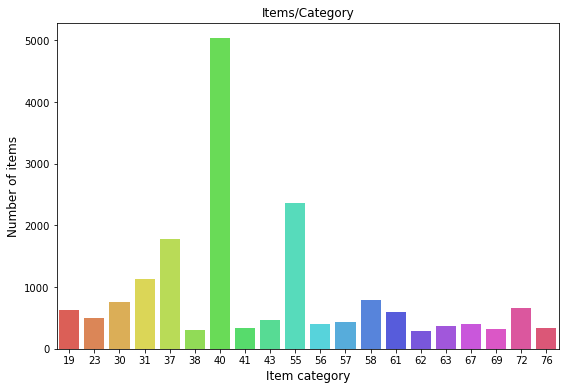

In [7]:
# how many products are in each category?
prod_per_cat = items.groupby(['item_category_id']).count()
prod_per_cat = prod_per_cat.sort_values(by='item_id', ascending=False)
prod_per_cat = prod_per_cat.iloc[0:20].reset_index()

plt.figure(figsize=(9, 6))

sns.barplot(x='item_category_id', y='item_id', data=prod_per_cat,
            palette='hls',
            capsize=0.05,
            saturation=8,
            errcolor='gray', errwidth=2,
            ci='sd'
            )

plt.title("Items/Category")
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Item category', fontsize=12)
plt.show()

Text(0, 0.5, 'Sales')

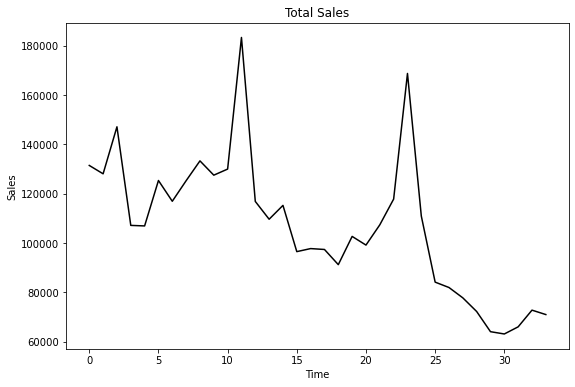

In [8]:
# total sales for one month
tot_amount = sales.groupby(["date_block_num"])["item_cnt_day"].sum().map(float)

plt.figure(figsize=(9, 6))
plt.plot(tot_amount, color='black')
plt.title('Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')

<AxesSubplot:xlabel='month', ylabel='item_cnt_day'>

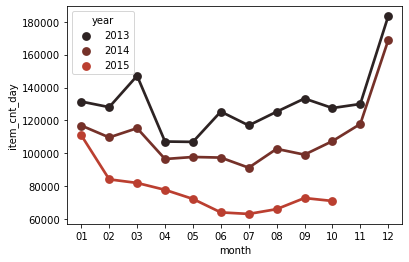

In [9]:
# calculate sales for every year
from datetime import datetime

sales['year'] = sales['date'].dt.strftime('%Y')
sales['month'] = sales['date'].dt.strftime('%m')

sales_group = pd.DataFrame(sales.groupby(['year', 'month'])[
                           'item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year',
              data=sales_group, color="#bb3f30")

<AxesSubplot:xlabel='month', ylabel='item_price'>

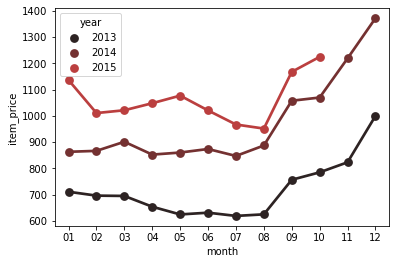

In [10]:
# price behaviour for every year
price_group = pd.DataFrame(sales.groupby(['year', 'month'])[
                           'item_price'].mean().reset_index())

sns.pointplot(x='month', y='item_price', hue='year',
              data=price_group, color="#bb3f3f")

2. Data Cleaning and Preparation

In [11]:
# items both in test and train sets
sales = sales[sales['item_id'].isin(test['item_id'].unique())]
# shops both in test and train sets
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]

In [12]:
# correct values for prices
sales = sales.query('item_price > 0')

In [13]:
sales.shape

(1224439, 8)

3. checking for outliers

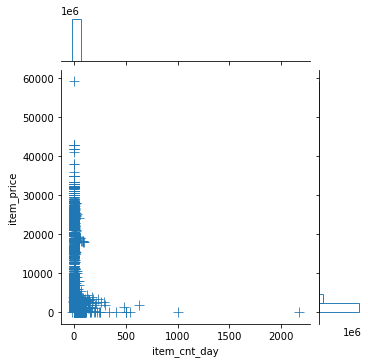

In [14]:
sns.jointplot(
    x="item_cnt_day", y="item_price", data=sales, height=5, 
    marker="+", s=100, marginal_kws=dict(bins=25, fill=False),
)

4. Prepare Data for Training

In [15]:
# collect sales for one month
sales_per_month = sales.groupby(["date_block_num", "shop_id", "item_id"])[
    "date_block_num", "date", "item_price", "item_cnt_day"]\
    .agg({"date_block_num": 'mean', "item_cnt_day": "sum", "item_price": "mean", "date": ["min", 'max']})

sales_per_month = sales_per_month.item_cnt_day.apply(list).reset_index()
sales_per_month.head()

,date_block_num,shop_id,item_id,sum
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0


In [16]:
# combine two dfs for training
sales_dataset = pd.merge(test, sales_per_month, on=[
                         'item_id', 'shop_id'], how='left')

sales_dataset.fillna(0, inplace=True)

sales_dataset.drop(['shop_id', 'item_id'], inplace=True, axis=1)

sales_dataset.head()

,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0


In [22]:
# expand sales_dataset to a pivot table
sales_dataset_pivot = sales_dataset.pivot_table(
    index='ID', columns='date_block_num', fill_value=0, aggfunc='sum')
sales_dataset_pivot.head()

sum                                               ...       \
date_block_num 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ... 24.0   
ID                                                                ...        
0                 0    0    0    0    0    0    0    0    0    0  ...    2   
1                 0    0    0    0    0    0    0    0    0    0  ...    0   
2                 0    0    0    0    0    0    0    0    0    0  ...    0   
3                 0    0    0    0    0    0    0    0    0    0  ...    0   
4                 0    0    0    0    0    0    0    0    0    0  ...    0   

                                                             
date_block_num 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
ID                                                           
0                 0    0    0    1    1    1    3    1    0  
1                 0    0    0    0    0    0    0    0    0  
2                 0    0    0    3    2    0    1    3    1  
3                 0    0    0    0    0    0    1    0    0  
4                 0    0    0    0    0    0    0    0    0  

[5 rows x 34 columns]

In [27]:
# train-teset split
X_train = np.expand_dims(
    sales_dataset_pivot.values[:, :-1], axis=2)  # without last column
y_train = sales_dataset_pivot.values[:, -1:]  # last column
# without first column
X_test = np.expand_dims(sales_dataset_pivot.values[:, 1:], axis=2)

print(f'X-train shape:{X_train.shape}\n y-train shape:{y_train.shape}\n X-test shape:{X_test.shape}')

X-train shape:(214200, 33, 1)
 y-train shape:(214200, 1)
 X-test shape:(214200, 33, 1)


5. Model